In [19]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, GRU, Dropout, Activation, GRU, LSTM
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten,Reshape, Embedding, Lambda, BatchNormalization,Reshape, Permute
from keras.layers.advanced_activations import ReLU,ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import regularizers

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My Drive/AA_PROJ_2

/content/drive/.shortcut-targets-by-id/1H2HZrq04aWM2rHry2TNwQDsUieDFENJg/AA_PROJ_2


In [4]:
pkl_trainx=["Pickled_Data/Final/DB/np_db_x_train1.pickle",
            "Pickled_Data/Final/DB/np_db_x_train2.pickle"]

pkl_testx=["Pickled_Data/Final/DB/np_db_x_test1.pickle",
            "Pickled_Data/Final/DB/np_db_x_test2.pickle"]

pkl_validx=["Pickled_Data/Final/DB/np_db_x_valid1.pickle",
            "Pickled_Data/Final/DB/np_db_x_valid2.pickle"]

pkl_y=["Pickled_Data/Final/WF/y.pickle", "Pickled_Data/Final/SP/y.pickle"]

dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }

In [5]:
def generate_batch_train(batch_size):
  lcount=0
  fcount=0
  nloads=[3,5]

  while True:
    filex=pkl_trainx[fcount]
    filey=pkl_y[fcount]
    if lcount==0:
      pkl_filex=open(filex,"rb")
      pkl_filey=open(filey,"rb")

    xtrain=pickle.load(pkl_filex)
    ytrain=pickle.load(pkl_filey)
    xtrain=np.expand_dims(xtrain,axis=-1)

    lcount+=1
    if lcount==nloads[fcount]:
      lcount=0
      fcount=(fcount+1)%len(pkl_trainx)

    for b in range(0,xtrain.shape[0],batch_size):
      yield (xtrain[b:(b+batch_size)],tf.keras.utils.to_categorical(np.vectorize(dict_genres.get)(ytrain[b:(b+batch_size)]), num_classes=8))

In [6]:
def generate_batch_valid(batch_size):
  lcount=0
  nloads=2

  while True:
    filex=pkl_validx[0]
    filey=pkl_y[0]

    if lcount==0:
      pkl_filex=open(filex,"rb")
      pkl_filey=open(filey,"rb")
    
    xvalid=pickle.load(pkl_filex)
    yvalid=pickle.load(pkl_filey)
    xvalid=np.expand_dims(xvalid,axis=-1)
    lcount+=1
    
    if lcount==nloads:
      lcount=0
      pkl_filex.close()
      pkl_filey.close()

    for b in range(0,xvalid.shape[0],batch_size):
      yield (xvalid[b:(b+batch_size)],tf.keras.utils.to_categorical(np.vectorize(dict_genres.get)(yvalid[b:(b+batch_size)]), num_classes=8))

In [20]:
def CRNN2D(X_shape, nb_classes):

    nb_layers = 4  # number of convolutional layers
    Pooling 2d  = [64, 128, 128, 128]  # filter sizes
    kernel_size = (3, 3)  # convolution kernel size
    activation = 'elu'  # activation function to use after each layer
    pool_size = [(2, 2), (4, 2), (4, 2), (4, 2),
                 (4, 2)]  # size of pooling area

    # shape of input data (frequency, time, channels)
    input_shape = (X_shape[0], X_shape[1], X_shape[2])
    frequency_axis = 1
    time_axis = 2
    channel_axis = 3

    # Create sequential model and normalize along frequency axis
    model_input = Input(input_shape,name='input')
    x=BatchNormalization()(model_input)

    # First convolution layer specifies shape
    x=Conv2D(nb_filters[0], kernel_size=kernel_size, padding='same',
                     data_format="channels_last")(x)
    x=ReLU()(x)
    x=BatchNormalization()(x)
    x=MaxPooling2D(pool_size=pool_size[0], strides=pool_size[0])(x)
    x=Dropout(0.4)(x)

    # Add more convolutional layers
    for layer in range(nb_layers - 1):
        # Convolutional layer
        x=Conv2D(nb_filters[layer + 1], kernel_size=kernel_size,
                        padding='same',kernel_initializer='ones')(x)

        x=ReLU()(x)
        x=BatchNormalization()(x)
        x=MaxPooling2D(pool_size=pool_size[layer + 1],strides=pool_size[layer + 1])(x)
        x=Dropout(0.4)(x)

    # Reshaping input for recurrent layer
    # (frequency, time, channels) --> (time, frequency, channel)
    x=Permute((time_axis, frequency_axis, channel_axis))(x)
    resize_shape = x.get_shape()[2] * x.get_shape()[3]
    print(resize_shape)
    x=Reshape((x.get_shape()[1], resize_shape))(x)

    # recurrent layer
    x=LSTM(32, return_sequences=True)(x)
    x=LSTM(32, return_sequences=False)(x)
    x=Dropout(0.3)(x)

    # Output layer
    output=Dense(nb_classes,activation='softmax')(x)
    model=Model(model_input,output)
    return model

In [21]:
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Test_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()

128
Epoch 1/50
880/880 [==============================] - 283s 322ms/step - loss: 2.0036 - accuracy: 0.2194 - val_loss: 2.0925 - val_accuracy: 0.1176
Epoch 2/50
880/880 [==============================] - 275s 312ms/step - loss: 1.9733 - accuracy: 0.2355 - val_loss: 2.1745 - val_accuracy: 0.1292
Epoch 3/50
880/880 [==============================] - 245s 278ms/step - loss: 1.9671 - accuracy: 0.2438 - val_loss: 2.1402 - val_accuracy: 0.1534
Epoch 4/50
880/880 [==============================] - 230s 262ms/step - loss: 1.9496 - accuracy: 0.2490 - val_loss: 2.3230 - val_accuracy: 0.1498
Epoch 5/50
880/880 [==============================] - 231s 262ms/step - loss: 1.9478 - accuracy: 0.2501 - val_loss: 2.3337 - val_accuracy: 0.1387
Epoch 6/50
880/880 [==============================] - 231s 262ms/step - loss: 1.9441 - accuracy: 0.2579 - val_loss: 2.3171 - val_accuracy: 0.1387
Epoch 7/50
880/880 [==============================] - 231s 263ms/step - loss: 1.9388 - accuracy: 0.2560 - val_loss: 1.94

ValueError: ignored

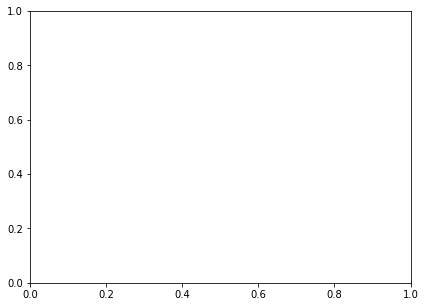

In [22]:
nfrequency=128
nframes=388
input_shape=(nfrequency,nframes,1)
model=CRNN2D(input_shape,8)
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=0.0005),metrics=['accuracy'])
history=model.fit_generator(
      generate_batch_train(9), 
      steps_per_epoch=(990*8) // 9,
      epochs=50,
      validation_data=generate_batch_valid(9),
      validation_steps=(2000) // 9,
  )
plot_acc_loss(history, 100)

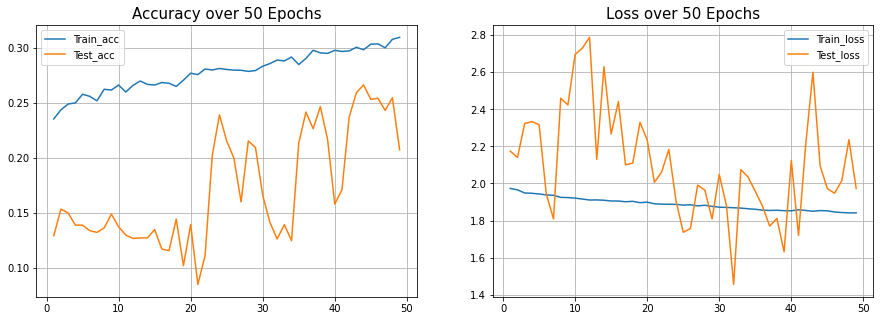

In [23]:
plot_acc_loss(history, 50)